In [8]:
import json 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.stats import mode
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans
import os
import datetime
from src.utils.utils import generate_steps

In [12]:
def read_csv_and_append_labels(csv_file, json):
    base_name = os.path.basename(csv_file)
    df = pd.read_csv(csv_file, parse_dates=['ds'])

    obj = list(filter(lambda x: x['file_name'] == base_name, json['prediction_results']))[0]
    labels = generate_steps(end_periods=obj['end_periods'], amplitude=obj['leakages'])
    df['labels'] = labels['amplitude']
    return df



In [6]:
read_csv_and_append_labels(f'train_data/scenario_week_example_11.csv', pd.read_json('train_data/results.json'))

,ds,Load current,Turbine current,Turbine speed,Turbine voltage,Pressure,labels
0,2022-03-01 00:00:00,127.664411,236.191794,5177.101335,12.502248,1.846338,0
1,2022-03-01 00:00:10,140.058095,236.831183,5182.801198,12.476912,1.846645,0
2,2022-03-01 00:00:20,127.516700,233.687038,5210.173487,12.524396,1.851536,0
3,2022-03-01 00:00:30,109.115956,239.117008,5150.269410,12.495953,1.810464,0
4,2022-03-01 00:00:40,131.182231,235.155452,5153.037716,12.545940,1.849103,0
...,...,...,...,...,...,...,...
60475,2022-03-07 23:59:10,319.718742,220.300152,5072.402716,12.344140,1.602796,1
60476,2022-03-07 23:59:20,326.223298,225.908253,5147.292902,12.322339,1.609502,1
60477,2022-03-07 23:59:30,306.939066,223.309874,5117.495285,12.295619,1.622940,1
60478,2022-03-07 23:59:40,315.036566,231.152069,5101.087262,12.448542,1.658232,1


In [39]:
def read_all_weeks_sup(tip = 'train_data'):
    unsupervised_datasets_path = tip+'/'
    li = []

    for week in range(100):
        filename = unsupervised_datasets_path + 'scenario_week_example_' + str(week) + r".csv"
        df = read_csv_and_append_labels(filename, pd.read_json(tip+'/results.json'))
        #df = pd.read_csv(filename, parse_dates=['ds'])
        df['ds'] = df['ds'] + datetime.timedelta(days=week*7)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame



df_full = read_all_weeks_sup('train_data')

df_full

,ds,Load current,Turbine current,Turbine speed,Turbine voltage,Pressure,labels
0,2022-03-01 00:00:00,137.577877,192.266230,4987.672253,12.452266,1.616853,1
1,2022-03-01 00:00:10,130.396550,211.991240,5059.988861,12.577009,1.612056,1
2,2022-03-01 00:00:20,129.974519,203.209446,5053.380319,12.597563,1.582803,1
3,2022-03-01 00:00:30,124.885127,205.589479,5013.702684,12.477872,1.621938,1
4,2022-03-01 00:00:40,118.682192,198.734198,5006.651464,12.492737,1.622493,1
...,...,...,...,...,...,...,...
6047995,2024-01-29 23:59:10,117.184065,210.186522,5508.607218,13.415217,1.904192,0
6047996,2024-01-29 23:59:20,115.857405,206.055950,5600.240711,13.476861,1.857968,0
6047997,2024-01-29 23:59:30,108.675852,196.814650,5501.599800,13.462923,1.864597,0
6047998,2024-01-29 23:59:40,109.593355,198.472657,5516.244950,13.526777,1.823254,0


In [28]:
X.max(),X.min()

(5868.08304746358, -4.789494003424446)

In [41]:
y.mean()

0.39436954365079363

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyClassifier

X = df_full.drop(['labels', 'ds'], axis=1).fillna(0).to_numpy()
y = df_full['labels'].fillna(0).to_numpy()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
clf = Pipeline([('scaler', StandardScaler()), 
                ('lr', LogisticRegression(random_state=0)) ])\
                .fit(X_train, y_train)
#('lr', LogisticRegression(random_state=0))
#clf.predict(X[:2, :])

#clf.predict_proba(X[:2, :])
print("fitted")

print(f'score: {clf.score(X_test, y_test)}')


print(f'mse: {mean_squared_error(clf.predict(X_test), y_test)}')
print(f'r2_score: {r2_score(clf.predict(X_test), y_test)}')

fitted
score: 0.8851671476671477
mse: 0.11483285233285233
r2_score: 0.4818970912813345


In [51]:
import pickle
with open('src/clf.pickle','wb') as f:
    pickle.dump(clf, f)

In [59]:
print(y_test)

[0 0 1 ... 0 1 1]


In [74]:
def read_all_weeks_train():
    unsupervised_datasets_path = r'C:\Users\hladn\FAKS\eestech challenge\train_data'
    li = []

    for week in range(100):
        filename = unsupervised_datasets_path + r"\scenario_week_example_" + str(week) + r".csv"
        #print(filename)
        df = pd.read_csv(filename, parse_dates=['ds'])
        df['ds'] = df['ds'] + datetime.timedelta(days=week*7)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

def read_all_weeks_test():
    unsupervised_datasets_path = r'C:\Users\hladn\FAKS\eestech challenge\test_data'
    li = []
    filenames = ["test_data\\" + f for f in os.listdir("test_data") if f.endswith("csv")]
    for filename in filenames:
        #print(filename)
        df = pd.read_csv(filename, parse_dates=['ds'])
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame


def visualise_week(df_week):
    fig = plt.figure(figsize=(16,8))
    plt.subplot(511)
    df_week["Load current "].plot(legend=True, color='k')
    plt.subplot(512)
    df_week["Pressure"].plot(legend=True, color='b')
    plt.subplot(513)
    df_week["Turbine current"].plot(legend=True, color='g')
    plt.subplot(514)
    df_week["Turbine speed"].plot(legend=True, color='c')
    plt.subplot(515)
    df_week["Turbine voltage"].plot(legend=True, color='y')
    

def visualise_week_train(df_week):
    fig = plt.figure(figsize=(16,8))
    plt.subplot(611)
    df_week["Load current "].plot(legend=True, color='k')
    plt.subplot(612)
    df_week["Pressure"].plot(legend=True, color='b')
    plt.subplot(613)
    df_week["Turbine current"].plot(legend=True, color='g')
    plt.subplot(614)
    df_week["Turbine speed"].plot(legend=True, color='c')
    plt.subplot(615)
    df_week["Turbine voltage"].plot(legend=True, color='y')
    plt.subplot(616)
    df_week["labels"].plot(legend=True, color='r')

In [68]:
df_all_weeks_train = read_all_weeks_train()
df_all_weeks_test = read_all_weeks_test()


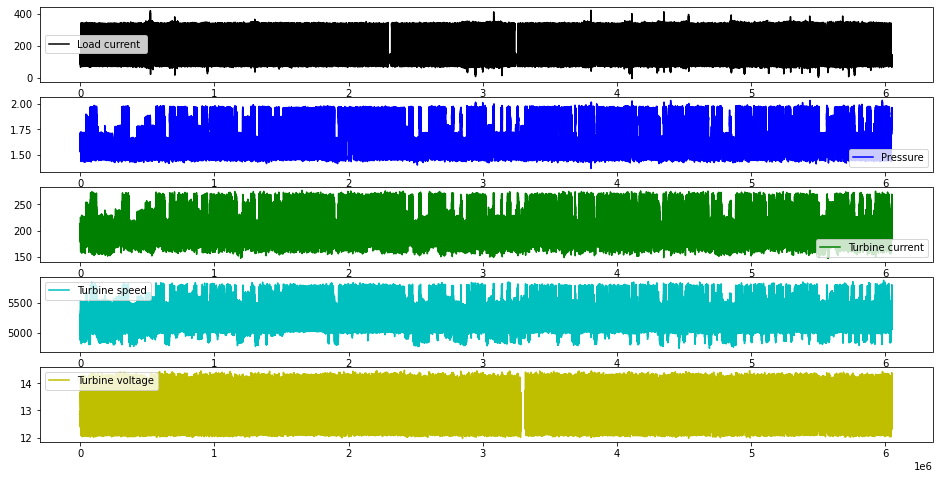

In [69]:
visualise_week(df_all_weeks_train)

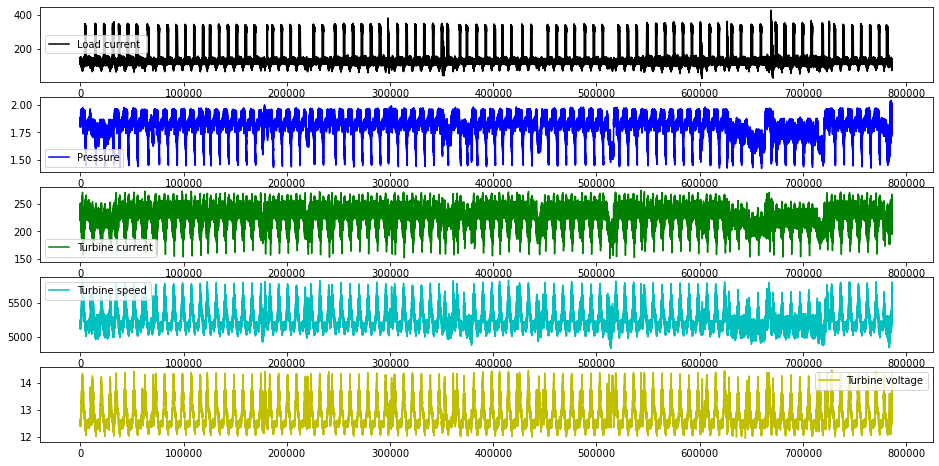

In [70]:
visualise_week(df_all_weeks_test)

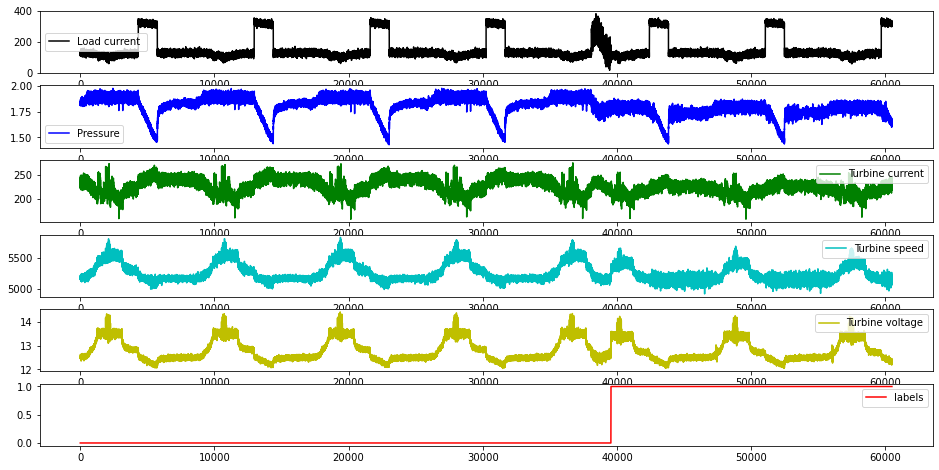

In [88]:
df_week = read_csv_and_append_labels(f'train_data/scenario_week_example_11.csv', pd.read_json('train_data/results.json'))
visualise_week_train(df_week)

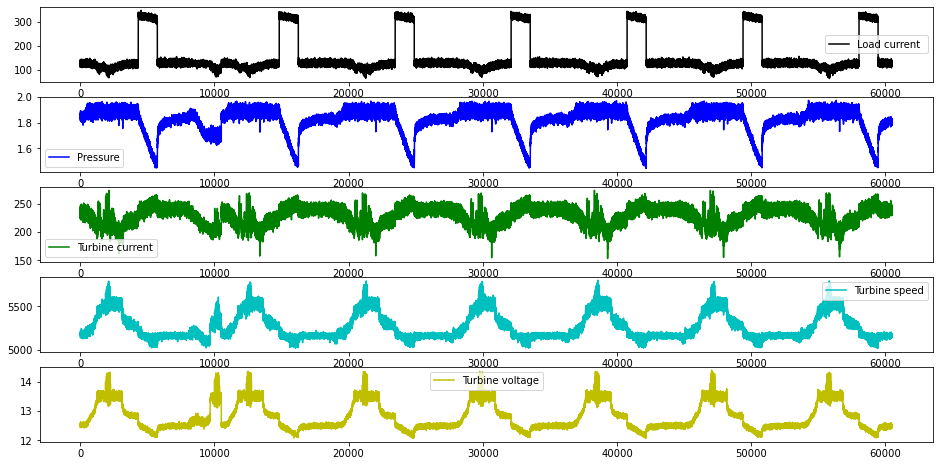

In [76]:
week_id = 59
def read_df_week(week_id):
    single_week_path = r"C:\Users\hladn\FAKS\eestech challenge\test_data\scenario_week_example_"+ str(week_id) + r".csv"
    df_week = pd.read_csv(single_week_path, index_col=None, header=0)
    return df_week
df_week = read_df_week(week_id)
visualise_week(df_week)